In [20]:
from sklearn.datasets import make_blobs, make_moons
import torch
from torch import nn
import pandas as pd
import seaborn as sns
import seaborn
from torch.optim import SGD
import torch.functional as F
import numpy as np

RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_decision_boundry(net, X, line='g--'):
    W = net.fc.weight[0].detach().cpu().numpy()
    b = net.fc.bias.detach().cpu().numpy()
    f = lambda x: (-W[0]/W[1]) * x +  (-b/W[1])
    dziedz = np.arange(-1, 1, 0.01)
    plt.plot(dziedz, f(dziedz), line) 
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))

# Prepare and Visualize data

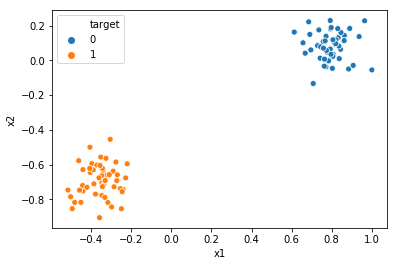

In [21]:
N_FEATURES = 2


X, Y = make_blobs(centers=2, center_box=(-10, 10), random_state=RANDOM_STATE, n_features=N_FEATURES)
# X, Y = make_moons()

X = X/np.abs(X).max()
# Y_one_hot = ohe.fit_transform(Y.reshape(-1, 1)).toarray()

data = pd.DataFrame(X, columns=['x1', 'x2'])
data['target'] = Y
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)

# Define the perceptron


![alt text](https://i.stack.imgur.com/2MVdW.png "Title")


In [22]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_out):

        super(Perceptron, self).__init__()
        self.fc = nn.Linear(n_in, n_out, bias=True)
    
    def forward(self, x):
        return self.fc(x)

def custom_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.05)
        
perceptron = Perceptron(2, 1)

# Linear layers get their weights initialized by default, but you can reinitialize them if needed.
perceptron.apply(custom_weights)

print("fc weight", perceptron.fc.weight)
print("bias weight", perceptron.fc.bias)


fc weight Parameter containing:
tensor([[-0.0108,  0.0517]], requires_grad=True)
bias weight Parameter containing:
tensor([0.0500], requires_grad=True)


/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Using CrossEntropy



While using crossentropy loss our model needs to return (BS, n_classes) output tensor, the target has to be a coresponding dense label vector of shape (BS, 1)

input shape (BS, n_classes): torch.Size([1, 2])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


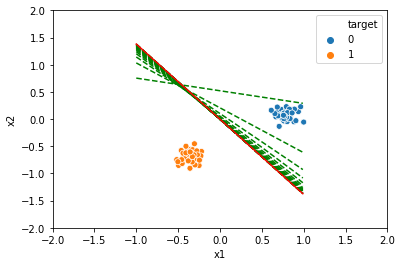

In [23]:
N_EPOCHS = 20

# init the model, loss and optimizer
net = Perceptron(2, 1)
optimizer = SGD(net.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
net = net.to(DEVICE)

loss_history = []
for epoch in range(N_EPOCHS):
    for xsample,ysample in zip(X, Y):

        # zero the gradients
        optimizer.zero_grad() 
        
        # batch preparation
        x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # forward pass
        out = net(x)
        
        # loss calculation
        loss = criterion(out, y)
        
        # calculating gradients
        loss.backward()
        
        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()
        
        #append calculated loss to the history
        loss_history.append(loss.detach().cpu().numpy())
        
    plot_decision_boundry(net, X)
    
# at the end plot final solution in red
plot_decision_boundry(net, X, 'r-')
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)

        
print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

Text(0,0.5,'loss (CE)')

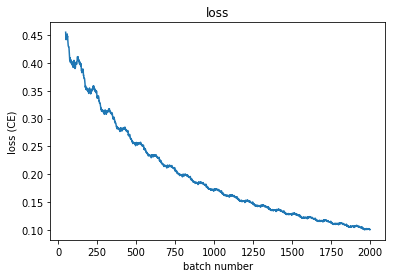

In [6]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss.rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

#### Exercises
- Play with the training loop, enojoy the fact that you can inspect all the values dynamically.
- Can you edit the Perceptron class to create a Multi Layer Perceptron? (ie having more then 0 hidden layers)
- Initialize the the initial weights to 0. What do you think will happen? Can we still train the perceptron?
- What kind of gradient descnet are we using here? Stochastic? Batch? or Vanilla?
- What does detach do and why do we have to call it? (use google)
 

In [27]:
from IPython.display import HTML
HTML('<iframe src=https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.19214&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false width=1000 height=600></iframe>')